## Fune-tune the System - Ada Boost Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
import module.utils.bin_class_utils as bin_class_utils
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
import pandas as pd
import time

In [2]:
start_time = time.time()

In [3]:
TRAIN_FILE_PATH = "../data/train_df.csv"
VALIDATION_FILE_PATH = "../data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "AdaBoostClassifier"

SAMPLE_SIZE = 0.2 # set a small number for development, set larger for formal train
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['uid',
 'app_score',
 'his_on_shelf_time',
 'task_id',
 'spread_app_id',
 'tags',
 'dev_id']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']

AB_HYPER_PARAM_GRID = {
    'preprocessor__numerical__imputer__strategy': ['mean'], # default 'mean'
    'preprocessor__categorical__target_encoder__smooth': ['auto'], # default 'auto'
    'estimator__n_estimators': [50, 100], # default 50
    'estimator__learning_rate': [1.0, 2.0, 5.0], # default 1.0
    'estimator__estimator__max_depth': [10, None], # default None
    'estimator__estimator__min_samples_split': [2], # default 2
    'estimator__estimator__min_samples_leaf': [1], # default 1
    'estimator__estimator__max_features': ['sqrt', None], # default None
}

BS_SAMPLE_NUM = 5

#### 1. Import data and identify attributes

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.2 fraction from DataFrame:
sample_df.shape: (134103, 36)


In [6]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]

In [7]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list

#### 2. Build composite estimator

In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])

composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     criterion='log_loss',
                                                                     random_state=42),
                                    random_state=42))])

#### 3. Design grid search and tune hyperparameters of composite estimator

In [ ]:
best_model = bin_class_utils.tune_hyperparameters(train_cap_x_df, train_y_df, composite_estimator, AB_HYPER_PARAM_GRID)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


#### 4. Evaluate hyperparameter-tuned estimator on train set

In [ ]:
eval_train_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, best_model, "train", CVS_SCORING_LIST)
eval_train_results

#### 5. Evaluate hyperparameter-tuned estimator on validation set

In [ ]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)

In [ ]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df

In [ ]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

In [ ]:
eval_validation_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, best_model, "validation", CVS_SCORING_LIST)
eval_validation_results

#### 6. Check out permutation feature importance

In [ ]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df

#### 7. Check for false discoveries

In [ ]:
bin_class_utils.avoiding_false_discoveries_class_helper(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    validation_cap_x_df,
    validation_y_df, 
    num_samples=BS_SAMPLE_NUM
)

#### 8. Tune classification threshold for classification - assess threshold list

In [ ]:
thresholds = np.arange(0, 1.1, 0.1)

bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,  
    thresholds
)

In [ ]:
bin_class_utils.plot_errors_to_threshold(
    best_model, 
    validation_cap_x_df, 
    validation_y_df, 
    'tuned validation'
)

#### 9. Higher resolution scan to get the best classification threshold

In [26]:
temp_best_threshold = 0.7

In [27]:
start = temp_best_threshold - 0.05
stop = temp_best_threshold + 0.06
step_size = 0.01

narrow_thresholds = np.arange(start, stop, step_size)
bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,
    narrow_thresholds
)


Classification Report at Threshold 0.65:

              precision    recall  f1-score   support

           0     0.9657    0.7792    0.8625      8092
           1     0.0351    0.2249    0.0607       289

    accuracy                         0.7601      8381
   macro avg     0.5004    0.5020    0.4616      8381
weighted avg     0.9336    0.7601    0.8348      8381


Classification Report at Threshold 0.66:

              precision    recall  f1-score   support

           0     0.9657    0.7892    0.8685      8092
           1     0.0351    0.2145    0.0603       289

    accuracy                         0.7694      8381
   macro avg     0.5004    0.5019    0.4644      8381
weighted avg     0.9336    0.7694    0.8407      8381

Classification Report at Threshold 0.67:

              precision    recall  f1-score   support

           0     0.9657    0.8014    0.8759      8092
           1     0.0354    0.2042    0.0604       289

    accuracy                         0.7808      8381


In [28]:
best_threshold = 0.71

#### 10. Evaluate the best classification threshold on validation set

Evaluate the trained estimator performance on best validation set
Check accuracy score
best validation set accuracy score: 0.8256771268345067

Check classification report
{'0': {'precision': 0.9659873506676037, 'recall': 0.8493573900148295, 'f1-score': 0.9039258236338528, 'support': 8092.0}, '1': {'precision': 0.03712480252764613, 'recall': 0.16262975778546712, 'f1-score': 0.060450160771704176, 'support': 289.0}, 'accuracy': 0.8256771268345067, 'macro avg': {'precision': 0.5015560765976249, 'recall': 0.5059935739001483, 'f1-score': 0.48218799220277847, 'support': 8381.0}, 'weighted avg': {'precision': 0.9339576076282948, 'recall': 0.8256771268345067, 'f1-score': 0.8748404559489511, 'support': 8381.0}}

Check confusion matrix
best validation set confusion matrix: 
[[6873 1219]
 [ 242   47]]
True Positives =  6873
True Negatives =  47
False Positives(Type I error) =  1219
False Negatives(Type II error) =  242

Check cross validation score

accuracy scores: [0.96541443 0.96599045 0.965393

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.


precision scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

recall scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

f1 scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

Check the ROC Curve and AUC


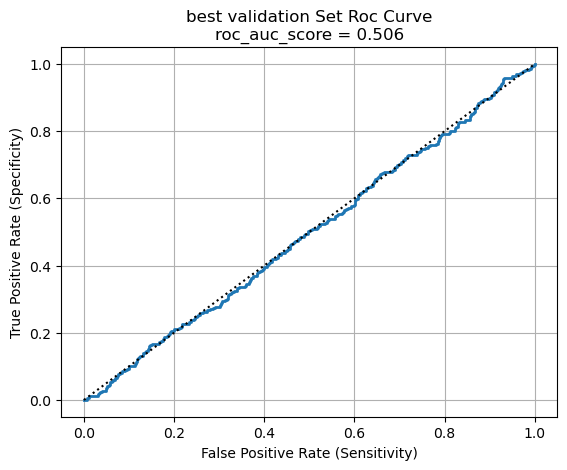


Check Precision-Recall Curve and Average Precision Score


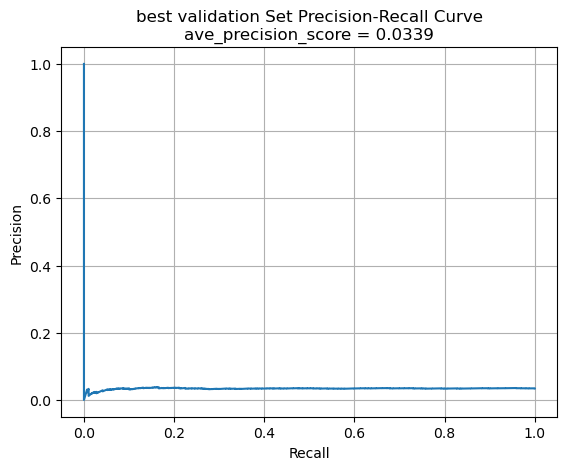

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,best validation,0.8257,0.037125,0.16263,0.9655,0.0,0.0,0.0,0.506


In [29]:
eval_best_validation_results = bin_class_utils.eval_class(
    validation_cap_x_df,
    validation_y_df,
    best_model,
    "best validation",
    CVS_SCORING_LIST,
    best_threshold
)
eval_best_validation_results

In [30]:
compare_df = pd.concat([eval_train_results, eval_validation_results, eval_best_validation_results], axis=0)
compare_df

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train,0.9491,0.132176,0.085640,0.9578,0.0968,0.0285,0.0403,0.5328
0,validation,0.9470,0.106599,0.072664,0.9655,0.0000,0.0000,0.0000,0.5255
0,best validation,0.8257,0.037125,0.162630,0.9655,0.0000,0.0000,0.0000,0.5060


#### 11. Save the best model with pickle

In [31]:
pickle.dump(best_model, open(ESTIMATOR_NAME + '.pkl', 'wb'))

In [32]:
end_time = time.time()
print(f'Script run time: {(end_time - start_time)/60} minutes')

Script run time: 8.237174916267396 minutes
